<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/ResNet_birds_keras_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.9.2
Running on TPU  ['10.112.239.202:8470']


In [61]:
from matplotlib import pyplot as plt

AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = 224
CHANNELS = 3
NUM_CLASSES = 100

def data_augment(image, label):
  modified = tf.image.random_flip_left_right(image)
  modified = tf.image.random_flip_up_down(modified)
  modified = tf.image.random_saturation(modified, 0, 2)
  #modified = tf.keras.preprocessing.image.random_shift(modified, 0.5, 0.5)
  #modified = tf.keras.preprocessing.image.random_shear(modified, 0.5)
  #modified = tf.keras.preprocessing.image.random_zoom(modified, 0.5)

  return modified, label



features = {
  'image': tf.io.FixedLenFeature([], tf.string), 
  'height': tf.io.FixedLenFeature([], tf.int64),
  'width': tf.io.FixedLenFeature([], tf.int64),
  'channels': tf.io.FixedLenFeature([], tf.int64),
  'label_text': tf.io.FixedLenFeature([], tf.string), 
  'label_onehot':  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
  'label_number': tf.io.FixedLenFeature([], tf.int64),
}

def parse_labels(example):
  parsed = tf.io.parse_single_example(example, features)
  
  return parsed['label_number'], parsed['label_text'] 

def get_label_map(filenames):
  labels_map = {}  
  records = tf.data.TFRecordDataset(filenames)
  dataset = records.map(parse_labels)   

  try:
    for label_number, label_text in dataset.as_numpy_iterator():
      labels_map[label_number] = label_text.decode('UTF-8')
  except tf.errors.OutOfRangeError:
    pass
  
  return labels_map

def parse_tfrecord(example):
  parsed = tf.io.parse_single_example(example, features)
  image = tf.image.decode_jpeg(parsed['image'], channels=3)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = tf.cast(image, tf.float32) / 255.0
  
  return image, parsed['label_onehot'], 

def open_images_with_labels(filenames):
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO) 

gcs_pattern = 'gs://brids-xarvel/*.tfrec'
filenames = tf.io.gfile.glob(gcs_pattern)

labels_map = get_label_map(filenames)
dataset = open_images_with_labels(filenames)  

dataset = dataset.shuffle(13000)

validation_dataset = dataset.take(1000).batch(100).prefetch(AUTO) 
train_dataset = dataset.skip(1000).map(data_augment, num_parallel_calls=AUTO).repeat().batch(100).prefetch(AUTO) 

Exception ignored in: <function Executor.__del__ at 0x7f938191ab00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [62]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications import Xception

def create_model():
  pretrained_model = ResNet152V2(input_shape=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS], include_top=False, weights=None)
  pretrained_model.trainable = True
  model = Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    Dense(100, activation='softmax')
  ])
  model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
  )
  return model

with tpu_strategy.scope(): 
  model = create_model()

history = model.fit(
    train_dataset,
    steps_per_epoch=400,
    validation_data=validation_dataset,
    epochs=30,
)

Epoch 1/30
400/400 [==============================] - 220s 221ms/step - loss: 3.8218 - accuracy: 0.1147 - val_loss: 5.9612 - val_accuracy: 0.0550
Epoch 2/30
400/400 [==============================] - 74s 185ms/step - loss: 2.6417 - accuracy: 0.3258 - val_loss: 4.9267 - val_accuracy: 0.1860
Epoch 3/30
400/400 [==============================] - 74s 186ms/step - loss: 1.8330 - accuracy: 0.5167 - val_loss: 1.9734 - val_accuracy: 0.5290
Epoch 4/30
400/400 [==============================] - 75s 187ms/step - loss: 1.2769 - accuracy: 0.6574 - val_loss: 1.3482 - val_accuracy: 0.6580
Epoch 5/30
400/400 [==============================] - 75s 188ms/step - loss: 0.9182 - accuracy: 0.7458 - val_loss: 0.9081 - val_accuracy: 0.7650
Epoch 6/30
400/400 [==============================] - 75s 187ms/step - loss: 0.6947 - accuracy: 0.8093 - val_loss: 0.8130 - val_accuracy: 0.7760
Epoch 7/30
400/400 [==============================] - 75s 188ms/step - loss: 0.5130 - accuracy: 0.8553 - val_loss: 0.4621 - val_a

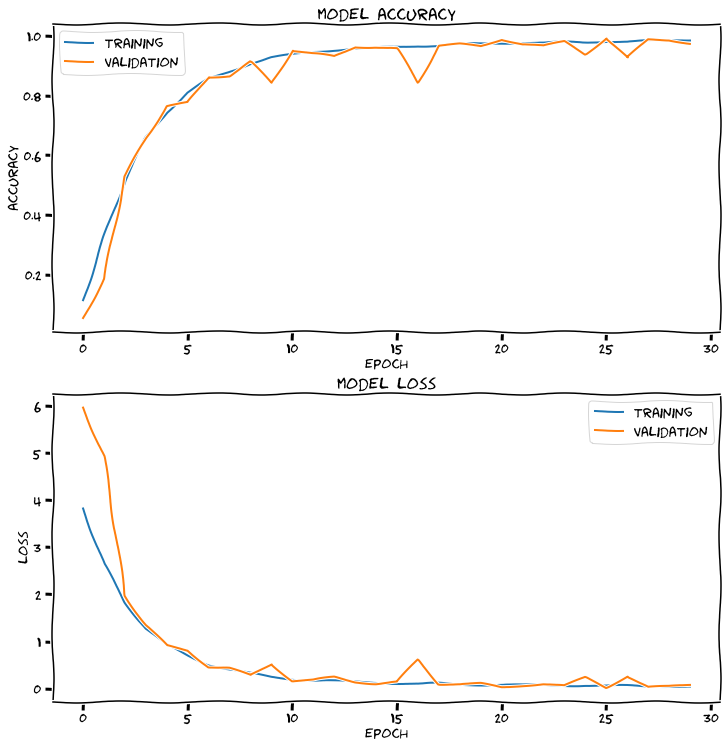

In [63]:
def display_training_curves(training, validation, title, subplot):
  with plt.xkcd():
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

1/1 [==============================] - 13s 13s/step


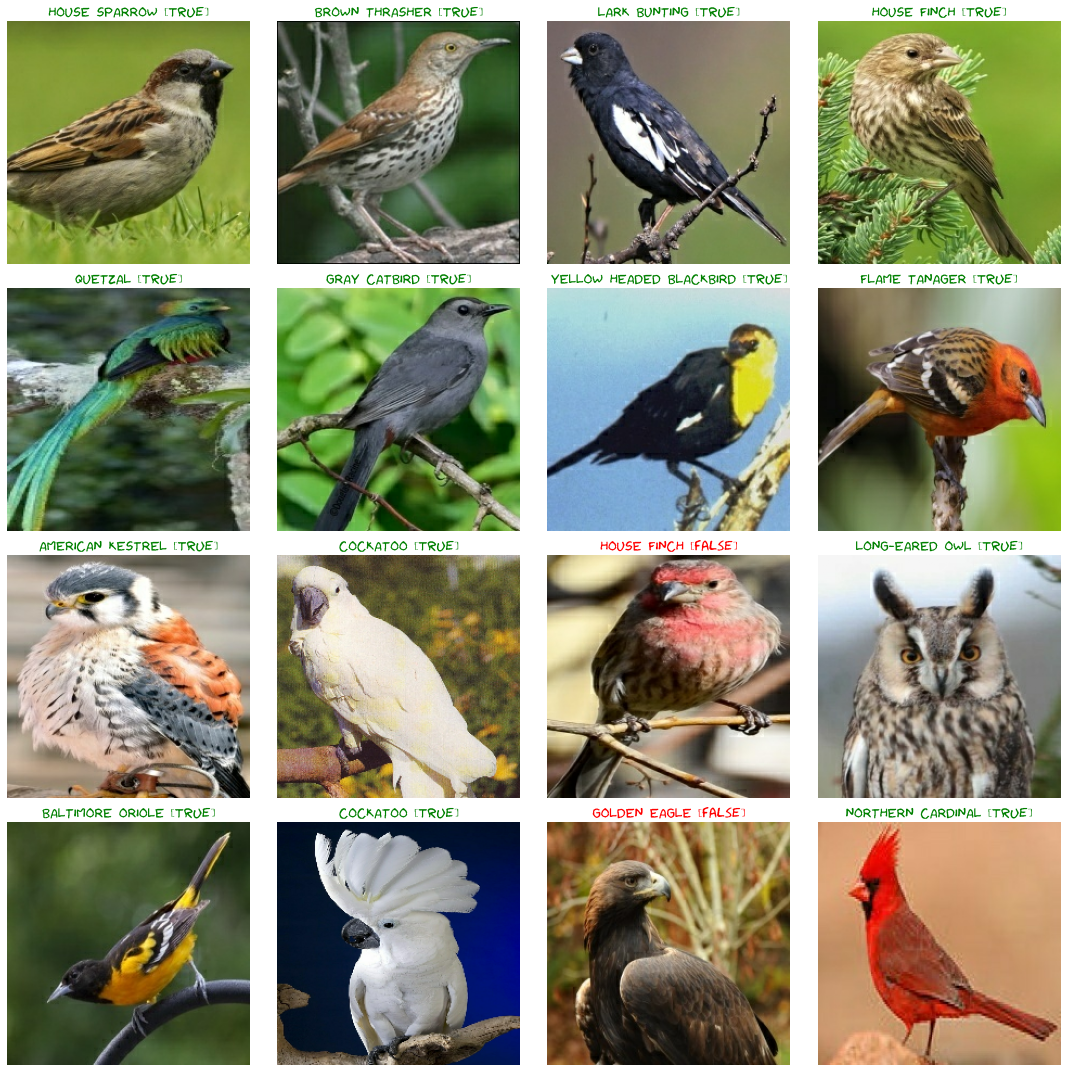

In [65]:
import numpy as np
evaluation_dataset = dataset.take(16).batch(16).prefetch(AUTO)

def display_image(image, predicted_label, true_label, index):
  with plt.xkcd():
    plt.subplot(4, 4, index)
    plt.axis('off')
    title = labels_map[true_label]
    veryfication_title = 'true' if predicted_label == true_label else 'false'
    color = 'green' if predicted_label == true_label else 'red'

    plt.title(title + ' [' + veryfication_title + ']', fontsize=14, color=color)
    plt.imshow(image)
  
images, true_one_hot_labels = evaluation_dataset.as_numpy_iterator().next()
predicted_one_hot_labels = model.predict(images)
predicted_labels = np.argmax(predicted_one_hot_labels, axis=1)
true_labels = np.argmax(true_one_hot_labels, axis=1)

images_labels = zip(images, predicted_labels, true_labels)

subplot = 441
plt.figure(figsize=(15,15))
i = 1
for image, predicted_label, true_label in images_labels:
  display_image(image, predicted_label, true_label, i)  
  i = i + 1
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [ ]:
loss, acc = model.evaluate(dataset.take(1000).batch(100))

In [66]:
'Accuracy: ' + str(acc)

'Accuracy: 0.987000048160553'